Workshop Tutorial: Running Jobs on External Compute Resources
============================

**IMPORTANT NOTE**: this entire tutorial covers new capabilities _since_ the 2.3 release. To run this, you need the 2.4 release of PHOEBE.


In this tutorial we cover the setup of external compute resources, with an emphasis on Villanova's departmental cluster 'terra', submission, and job management.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Servers](http://phoebe-project.org/docs/2.4/tutorials/server.ipynb)


Setup
-----------------------------

We start with the bundle from the previous tutorial to show examples of running both a forward-model and the solver remotely on terra.

In [1]:
import phoebe
from phoebe import c, u

logger = phoebe.logger('error')

b = phoebe.open('data/synthetic/after_optimizers.bundle')

Server Configuration
-----------------------------

PHOEBE makes use of [crimpl](http://crimpl.readthedocs.io) as a built-in depedency to manage submitting and monitoring jobs on external compute resources.  In order to make use of one of these server, you must first configure the server within [crimpl](http://crimpl.readthedocs.io) (this only needs to be done once, after which the name of the crimpl server can be referenced from within PHOEBE on your local machine).

The available server types include:
* [LocalThread](https://crimpl.readthedocs.io/en/latest/LocalThread/)
* [RemoteThread](https://crimpl.readthedocs.io/en/latest/RemoteThread/)
* [RemoteSlurm](https://crimpl.readthedocs.io/en/latest/RemoteSlurm/)


For the workshop, you already have a temporary account with passwordless ssh to terra, so we will configure that server within crimpl now.

In [2]:
from phoebe.dependencies import crimpl

Note that whatever you put as `host` needs to be ssh-able without a password.  If you do not have `terra` as an alias in your ssh config, you may need `host="username@terra.villanova.edu"` instead.

In [3]:
s = crimpl.RemoteSlurmServer(host='terra', directory='~/workshop/crimpl')

In [4]:
print(s)

<RemoteSlurmServer host='terra' directory='~/workshop/crimpl' ssh='ssh' scp='scp' mail_user=None>


We will use conda on the remote server to manage installing any necessary dependencies.  You can manually install and configure conda, or let `crimpl` do it for you (if conda is already detected as installed, this won't do any harm to call again).

In [5]:
s.install_conda(in_server_directory=True)

# crimpl: ssh terra "mkdir -p ~/workshop/crimpl"
# crimpl: scp exportpath.sh terra:~/workshop/crimpl/
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; cd ~/workshop/crimpl; wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh; sh Miniconda3-latest-Linux-x86_64.sh -u -b -p ./crimpl-conda; mkdir ./crimpl-bin; cp ./crimpl-conda/bin/conda ./crimpl-bin/conda"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda init"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"


True

We will have PHOEBE manage installing the dependencies for us at each job submission.  This does add some minimal overhead to check the existing installation, but will fairly quickly see all dependencies met and move on.

Note: if running crimpl on a non-release branch of PHOEBE (`feature-pulsations`, `feature-blending`), this will force a re-install to the latest version of that branch for each job. In that case, or when you want to install a dependency manually, you could reference the same conda environment from within PHOEBE, and set `install_deps=False` to skip having PHOEBE check and install dependencies.

Any released and tagged version, however, will not force a re-install.

You can always call [b.dependencies()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.dependencies.md) to see the required pip dependencies for a given bundle:

In [7]:
b.dependencies()

(['phoebe==2.4.1'], [])

Thus, to run this bundle on a remote server, phoebe 2.4.1 is the only needed dependency. That said, we will use MPI and MCMC in the future so we will install two additional packages, mpi4py and emcee:

In [10]:
s.run_script(['export MPICH_CC=clang CC=clang; pip install phoebe mpi4py emcee --ignore-installed'], conda_env='phoebe_workshop')

# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; mkdir -p ~/workshop/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/workshop/crimpl/
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; cd ~/workshop/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh 2> ./crimpl_run_script.sh.err"


This entire process only needed to be run this one time. Now that the environment is built and ready, we will save it and activate it on subsequent use:

In [11]:
s.save('terra', overwrite=True)

'/home/andrej/.crimpl/servers/terra.json'

The name provided when saving the crimpl configuration is the same name that we will reference later in PHOEBE as `crimpl_name`.  This keeps all the server configuration and potential sensitive information out of the bundle so that the bundle (or notebook) can safely be saved and shared, while also not requiring the servers to be re-configured in each case.  If `crimpl_name` is not available from `crimpl` on the local machine, an error will be raised and the server can easily be configured or swapped.

Servers in the Bundle
-------------------------------

Servers in the bundle are added and managed as any other set of options via [b.add_server()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.add_server.md) and with "kinds" for each of the supported crimpl server types listed above:

* [localthread](http://phoebe-project.org/docs/2.4/api/phoebe.parameters.server.localthread.md)
* [remoteslurm](http://phoebe-project.org/docs/2.4/api/phoebe.parameters.server.remoteslurm.md)
* [awsec2](http://phoebe-project.org/docs/2.4/api/phoebe.parameters.server.awsec2.md)

In [12]:
b.add_server(
    kind='remoteslurm',
    server='terra',
    crimpl_name='terra',
    conda_env='phoebe_workshop',
    nprocs=48,
    overwrite=True
)

<ParameterSet: 11 parameters | qualifiers: use_conda, use_mpi, install_deps, walltime, conda_env, mail_type, crimpl_name, nprocs, mail_user, slurm_job_name, isolate_env>

Note that there are a few other useful options here, including `walltime`.  We will leave that at the default 30 minutes for now, but for longer jobs, you will likely want to extend this to a reasonable value (terra allows up to 48 hours walltime per-job).

In [13]:
print(b.get_server('terra'))

ParameterSet: 10 parameters
         crimpl_name@terra@server: terra
           use_conda@terra@server: True
           conda_env@terra@server: phoebe_workshop
         isolate_env@terra@server: False
              nprocs@terra@server: 48
             use_mpi@terra@server: True
        install_deps@terra@server: True
      slurm_job_name@terra@server: 
            walltime@terra@server: 0.5 h
           mail_user@terra@server: 


The `use_server` parameter
--------------------------

The compute and solver options both have `use_server` parameters that govern where [b.run_compute()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.run_compute.md) and [b.run_solver()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.run_solver.md) will be run. If `'none'` (default), the job is run in the current thread. The `use_server` in solver options are set to 'compute' by default, which means they will fall back on the `use_server` parameter in the referenced compute options.

In [15]:
print(b.filter(qualifier='use_server'))

ParameterSet: 9 parameters
      use_server@phoebe01@compute: none
        use_server@nm_fit@compute: none
       use_server@rvperiod@solver: none
   use_server@lcperiod_bls@solver: none
    use_server@lcperiod_ls@solver: none
         use_server@rvgeom@solver: none
       use_server@ebai_est@solver: none
         use_server@lcgeom@solver: none
      use_server@nm_solver@solver: compute


If running the `nm_solver`, for example, PHOEBE will use the solver options for the `nm_fit` compute options.

In [16]:
print(b.filter(qualifier='compute'))

ParameterSet: 1 parameters
         compute@nm_solver@solver: nm_fit


As with any other parameter in compute or solver options, these can either be set or overridden as keyword arguments when calling [b.run_compute()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.run_compute.md) and [b.run_solver()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.run_solver.md), respectively.

Running External Jobs with crimpl
--------------------------------

There are several use-cases for running compute or solver jobs on external servers.

**1. Wait and load results automatically:**

We can pass kwargs to `run_compute()` or `run_solver()` to override any compute/solver options. Here we can pass the server tag (note: this is the PHOEBE server tag, not the crimpl server name) to `run_compute()`, overriding the `use_server` parameter, which then looks up the server options, loads the corresponding crimpl object, and passes the job to the remote machine.

Once the job is submitted, PHOEBE will poll to check its status, and retrieve the results once complete (or failed).

In [17]:
b.run_compute(compute='phoebe01', use_server='terra', model='terra_model')

# crimpl: ssh terra "mkdir -p ~/workshop/crimpl"
# crimpl: scp exportpath.sh terra:~/workshop/crimpl/
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; mkdir -p ~/workshop/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/workshop/crimpl/
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; cd ~/workshop/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh 2> ./crimpl_run_script.sh.err"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-job-*"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/andrej/workshop/crimpl/crimpl-job-2022.06.14-15.53.40/*"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh;

<ParameterSet: 8 parameters | kinds: lc, rv>

/home/andrej/system/venvs/phoebe-dev/lib/python3.10/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


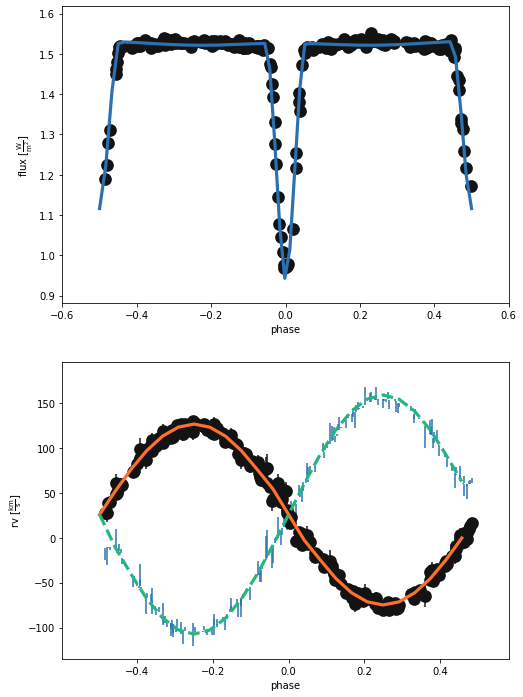

In [18]:
_ = b.plot(model='terra_model', x='phases', show=True)

**2. Detach and monitor/retrieve results:**

For long(er) jobs, we can submit the job and immediately detach from `run_compute()` or `run_solver()`.  This results in a "Job" parameter in the model or solution, holding the necessary information to check the progress and retrieve the results at any time in the future. 

This is particularly useful for long solver runs as it allows you to monitor their progress *as* they are running, interrupting the job early if necessary. In order to do that, we need to set `progress_every_niters` in the solver options (not available for all solvers). This tells the solver to query progress every given number of iterations, which can then be retrieved, loaded, and inspected.  This functionality does come with some overhead, so you do not want to set this to 1.

In [19]:
print(b.get_solver('nm_solver'))

ParameterSet: 13 parameters
        comments@nm_solver@solver: 
      use_server@nm_solver@solver: compute
         compute@nm_solver@solver: nm_fit
   expose_lnprobabilities@nm_s...: False
   continue_from@nm_solver@solver: None
   fit_parameters@nm_solver@so...: ['teffratio@binary', 'requiv@primary', 'requivratio@binary']
   initial_values@nm_solver@so...: {}
          priors@nm_solver@solver: ['dist01']
         maxiter@nm_solver@solver: 20
        adaptive@nm_solver@solver: False
           xatol@nm_solver@solver: 0.0001
           fatol@nm_solver@solver: 0.0001
   progress_every_niters@nm_so...: 0


In [20]:
print(b.get_parameter(qualifier='progress_every_niters', solver='nm_solver'))

Parameter: progress_every_niters@nm_solver@solver
                       Qualifier: progress_every_niters
                     Description: save the progress of the solution every n iterations.  The solution can only be recovered from an early termination by loading the bundle from a saved file and then calling b.import_solution(filename).  The filename of the saved file will default to solution.ps.progress within run_solver, or the output filename provided to export_solver suffixed with .progress.  If using detach=True within run_solver, attach job will load the progress and allow re-attaching until the job is completed.  If 0 will not save and will only return after completion.
                           Value: 0
                  Constrained by: 
                      Constrains: None
                      Related to: None



Here we'll set `progress_every_niters=10`, `maxiter=1e6`, and `fatol=xatol=1e-12`... essentially telling the optimizer to continue running until its manually terminated or exceeds the walltime.

In [21]:
b.set_value('progress_every_niters', solver='nm_solver', value=10)
b.set_value('maxiter', solver='nm_solver', value=1e6)
b.set_value('xatol', solver='nm_solver', value=1e-12)
b.set_value('fatol', solver='nm_solver', value=1e-12)

In [22]:
b.run_solver(solver='nm_solver', use_server='terra', 
             solution='nm_solution_progress', detach=True)

# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; mkdir -p ~/workshop/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/workshop/crimpl/
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; cd ~/workshop/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh 2> ./crimpl_run_script.sh.err"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-job-*"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/andrej/workshop/crimpl/crimpl-job-2022.06.14-15.59.42/*"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/workshop/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-envs/*"
# crimpl: ssh terra "l

<Parameter: detached_job=unknown | keys: description, value, job_name, uniqueid, readonly, advanced, latexfmt>

In [23]:
print(b.get_solution('nm_solution_progress'))

ParameterSet: 2 parameters
R  detached_job@nm_solution_pr...: unknown
   comments@nm_solution_progre...: 


We can now (optionally) save the bundle, turn off our local machine, start a new python session, load the bundle, and all necessary information to check the job's status and retrieve results are handled automatically (with job information in the detached_job parameter and server setup/credentials in the crimpl configuration to avoid any security concerns when sharing bundles).

In [24]:
b.save('running_job.phoebe')

import phoebe
b = phoebe.open('running_job.phoebe')

Depending on how long we expect the job to take, there is a number of available methods we can call to act on this "job" parameter:

* [b.get_job_status()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.get_job_status.md)
* [b.get_job_crimpl_object()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.get_job_crimpl_object.md)
* [b.attach_job()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.attach_job.md)
* [b.load_job_progress()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.load_job_progress.md)
* [b.kill_job()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.kill_job.md)
* [b.resubmit_job()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.resubmit_job.md)

Let us now call [b.get_job_status()](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.get_job_status.md) to confirm that the job has started running:

In [25]:
b.get_job_status(solution='nm_solution_progress')

# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-job-*"
# crimpl: ssh terra "ls -d ~/workshop/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "cat /home/users/andrej/workshop/crimpl/crimpl-job-2022.06.14-15.59.42/crimpl_slurm_id"
# crimpl: ssh terra "squeue -j 4389"


'running'

Calling [b.load_job_progress](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.load_job_progress.md) will fail until the first progress file is written, so just for the sake of letting the notebook run by executing all cells, we'll force sleeping for 2 minutes.  Once it does succeed, it will download the latest dumped progress file and import it into the solution.

In [23]:
from time import sleep
sleep(120)

In [26]:
b.load_job_progress(solution='nm_solution_progress')

# crimpl: ssh terra "ls /home/users/andrej/workshop/crimpl/crimpl-job-2022.06.14-15.59.42/*"
# crimpl: ssh terra "ls /home/users/andrej/workshop/crimpl/crimpl-job-2022.06.14-15.59.42/*"
# crimpl: scp terra:/home/users/andrej/workshop/crimpl/crimpl-job-2022.06.14-15.59.42/_ZiAgdbaMSwGcqcjcPsJOhXQtgofTyH.out.progress ./


<ParameterSet: 11 parameters | qualifiers: success, message, fitted_twigs, niter, fitted_values, fitted_units, adopt_parameters, adopt_distributions, adopt_values, initial_values, fitted_uniqueids>

In [27]:
print(b.filter(qualifier=['fitted_twigs', '*_values', '*_lnprobability', 'niter', 'message'], 
               solution='nm_solution_progress'))

ParameterSet: 6 parameters
R  fitted_twigs@nm_solution_pr...: ['teffratio@binary@orbit@component' 'requiv@primary@star@component'
 'requivratio@binary@orbit@component']
   adopt_values@nm_solution_pr...: True
R  message@nm_solution_progres...: running
R  niter@nm_solution_progress@...: 10
R  initial_values@nm_solution_...: [0.9253032558087774 1.278524732928571 1.0818826670433095]
R  fitted_values@nm_solution_p...: [0.9253032558087774 1.278524732928571 1.0818826670433095]


This "snapshot" represents a fully functional bundle; for example, we can compute the forward model:

In [28]:
b.run_compute(compute='nm_fit', solution='nm_solution_progress', model='progress_model')

100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


<ParameterSet: 13 parameters | kinds: lc, rv>

Plot it:

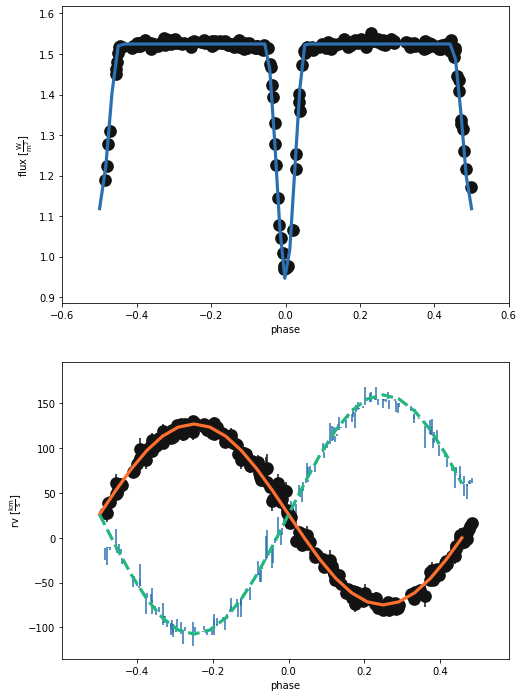

In [29]:
_ = b.plot(model='progress_model', x='phases', show=True)

We can keep running this loop of code blocks to re-load the latest progress file from the server (automatically overwriting the previous progress), compare results, and decide whether to keep it running or terminate the job.

If we are happy with the results before `maxiter`, `xatol`, `fatol` or the server's `walltime` have been reached, we can kill the job.  

In [30]:
b.kill_job(solution='nm_solution_progress')

# crimpl: ssh terra "scancel 4389"


<ParameterSet: EMPTY>

**3. Export the script:**

The last use case is when we want to circumvent crimpl altogether and submit the script ourselves. This is considered an advanced topic that is documented in the [online servers tutorial](http://phoebe-project.org/docs/2.4/tutorials/server.ipynb). It explains several options, including exporting a script that is capable of submitting the job externally, or a script to copy and submit manually. We will not go into the details of this use case here but provide a link for reference if you happen to be interested in this option.